In [1]:
import os, pickle, sys
from absl import logging
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
from arguments import get_args
logging.get_absl_handler().python_handler.stream = sys.stdout

Training, evaluation, optimization, and testing can be run different modes. These modes will be covered in this tutorial.\
First import the necessary modules and set some arguments for training.

In [2]:
from config import get_config, get_path_dict
from train import Trainer

args = get_args()
args = get_config(args)
args.n_episodes = 100
args.load_every = 10
args.len_cross_val = 200
args.len_dataset = 10
args.batch_size = 4
args.min_len_block = 1
args.device = pt.device('cuda' if pt.cuda.is_available() else 'cpu')
path_dict = get_path_dict(f'{args.train_dataset_id}')
if not os.path.exists('results'):
    os.makedirs('results')

/opt/homebrew/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


All modules are controlled via the configurations defined in `config.py`. Apart from the paths for retrieving and saving data, the file defines the variables `train_type`, `eval_type`, `search_hp_type`, and `test_type`.

The `train_type` can be `basic`, `online`, or `prior`. Datapoints where the network detects the position with below-threshold accuracy are not included in the batch. The rate at which the threshold `args.pixel_cutoff` constricts over training is controlled by `args.T_pixel_cutoff`, and the maximum number of frames not included before continuing is controlled by `args.max_n_reject`.\
If `args.train_type = 'basic'`, training proceeds as in the basic tutorial.\
If `args.train_type = 'online'`, training proceeds by loading new data every iteration. This means `args.len_dataset = args.batch_size`\
If `args.train_type = 'prior'`, training proceeds by loading test statistics from data already evaluated by using `eval_baseline`. After loading, the datapoints where the baseline test returned above-threshold error values are used form prioritized re-training.

In [3]:
args.train_type = 'online'
trainer = Trainer(args, path_dict)
trainer.train()

INFO:absl:iteration: 0 --- loss: 2.1647040843963623
INFO:absl:cross validate
INFO:absl:epoch: 0 --- loss: 2.1647040843963623 --- cross val ratio: 0.0
INFO:absl:iteration: 50 --- loss: 0.005970073398202658
INFO:absl:finis


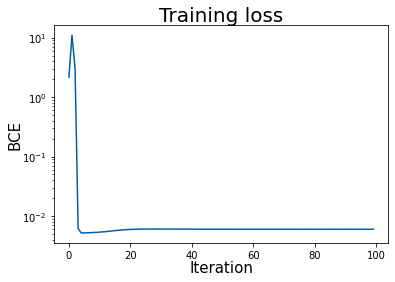

In [4]:
losses = pickle.load(open('results/train_loss', 'rb'))
plt.plot(losses, c='#065da4')
plt.yscale('log')
plt.xlabel('Iteration', labelpad=0, size=15)
plt.ylabel('BCE', labelpad=0, size=15)
plt.title('Training loss', pad=0, size=20);

Evaluation can be performed with and without using the model for inference.\
If `args.eval_type = model-based`, the function `eval_baseline()` is called and evaluation proceeds as described in the basic tutorial.\
If `args.eval_type = model-free`, evaluation is performed based on evaluation statistics from an earlier `eval_baseline()` call. The same data can be evaluated with different hyperparameter combinations without using the model, which increases inference time by a factor of 30. In this case, only the estimates of the coordinates are saved.

In [5]:
from evaluate import eval_baseline, eval_opt
from model import Model

args = get_args()
args = get_config(args)
args.min_len_block = 1
test_path_dict = get_path_dict(f'{args.train_dataset_id}')
state_dict_path = f'{args.state_dict_path}'
model = Model(args, core_type = args.core_type).to(args.device)
model.load_state_dict(pt.load(state_dict_path, map_location=f'{args.device}'), strict=False)
eval_baseline(args, test_path_dict, model)

  0%|                                                     | 0/9 [00:00<?, ?it/s]/opt/homebrew/lib/python3.9/site-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 22.48it/s]


In [6]:
from general_utils import get_hp
correlation_scale, hard_boundary = get_hp(args.hp)
eval_opt(args, test_path_dict, correlation_scale, hard_boundary)

100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 6940.38it/s]


Hyperparameter search can also be performed with and without using the model for inference.\
If `args.search_type = model-based`, hyperparameter search is performed by random search of the space of available parameters defined by `args.corre` and `args.hard_boundary`. The model is being used, making the search procedure for large spaces prohibitively expensive.\
If `args.search_type = model-free`, search is performed based on evaluation statistics from an earlier `eval_baseline()` call. The search time becomes faster by a factor of 30 (about 60,000 iterations per second with a well-trained model on our servers), which allows for exhaustive random search over the whole space.

In [7]:
from search_hp import search_hp_model_free
args.n_epochs_opt_hyperp = 10
search_hp_model_free(args, test_path_dict, args.n_epochs_opt_hyperp)

INFO:absl:(6.158482110660267e-05, 60.0)
100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 9472.71it/s]
INFO:absl:(0.0012742749857031347, 120.0)
100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 9967.98it/s]
INFO:absl:(0.0012742749857031347, 80.0)
100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 9463.21it/s]
INFO:absl:(0.0006951927961775605, 80.0)
100%|██████████████████████████████████████████| 9/9 [00:00<00:00, 10079.77it/s]
INFO:absl:(0.0012742749857031347, 70.0)
100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 9595.51it/s]
INFO:absl:(0.5455594781168519, 80.0)
100%|██████████████████████████████████████████| 9/9 [00:00<00:00, 10069.01it/s]
INFO:absl:(0.00020691380811147902, 180.0)
100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 9383.23it/s]
INFO:absl:(0.000379269019073225, 90.0)
100%|██████████████████████████████████████████| 9/9 [00:00<00:00, 10125.73it/s]
INFO:absl:(0.16237767391887217, 8

Testing can be performed by using the ground truth offsets with `args.test_type = 'test'`, or by simulating live tracking with `args.test_type = 'track'`, as described in the basic tutorial.